# Multi-View-Majority-Vote-Learning-Algorithms-Direct-Minimization-of-PAC-Bayesian-Bounds

This Notebook contains everything necessary to reproduce the experiments in our paper:  

*Multi-View Majority Vote Learning Algorithms: Direct Minimization of PAC-Bayesian Bounds*

## Imports

In [1]:
# %pip install -r requirements.txt

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from termcolor import colored

# Scikit-learn
from sklearn import preprocessing
from sklearn.utils import check_random_state
RAND = check_random_state(42)

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from mvpb.dNDF import MultiViewBoundsDeepNeuralDecisionForests


# Import data
from mvlearn.datasets import load_UCImultifeature
from data.datasets import (SampleData,
                           MultipleFeatures,
                           MNIST_MV_Datasets,
                           Nutrimouse,
                           ReutersEN,
                           IS,
                           CorelImageFeatures,
                           ALOI,
                           train_test_split,
                           train_test_merge,
                           s1_s2_split,
                           multiclass_to_binary)
from mvpb.util import uniform_distribution

## Load and prepare the multiview datasets

In [2]:
dataset = CorelImageFeatures()
X_train, y_train, X_test, y_test = dataset.get_data()
if y_train.ndim == 2:
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)
np.unique(y_train)
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [3]:
X_train[1].shape, y_train.shape, X_test[1].shape, y_test.shape

((700, 7), (700,), (300, 7), (300,))

In [4]:
Xs_train = []
Xs_test = []
for xtr, xts in zip(X_train, X_test):
    scaler = preprocessing.MinMaxScaler().fit(xtr)
    Xs_train.append(scaler.transform(xtr))
    Xs_test.append(scaler.transform(xts))

X_train_concat = [np.concatenate(Xs_train, axis=1)]
X_test_concat = [np.concatenate(Xs_test, axis=1)]

In [5]:
RUNS = np.unique(y_train)
if isinstance(dataset, (CorelImageFeatures, IS, MNIST_MV_Datasets)):
    unique_labels = dataset.get_real_classes(RUNS)
else:
    unique_labels = RUNS
OPTIMIZE_LAMBDA_GAMMA = False
TO_BINARY  = True
TO_OVR = False
USE_UNLABELED = False
s1_size = 0.1 if USE_UNLABELED else 1
bounds = ['TND_DIS', 'TND', 'DIS', 'Lambda', 'PBkl']
m = y_train.size #350
test_size = 1 - (m  / (y_test.size+y_train.size))

experiments = []

Xs, y = train_test_merge(Xs_train, y_train, Xs_test, y_test)
for idx, run in enumerate(RUNS[:3]):
    print(colored(f"----------------Run {idx+1}, on label {unique_labels[idx]}---------------", 'blue'))

    # Shuffle ans split the dataset into training and testing
    Xs_train, y_train, Xs_test, y_test = train_test_split(Xs, y, test_size=test_size, random_state=run)
    # Transform to binary if needed
    if TO_OVR:
        Xs_train, y_train, Xs_test, y_test = multiclass_to_binary(Xs_train, y_train, Xs_test, y_test, run)
    else:
        if isinstance(dataset, (MultipleFeatures, MNIST_MV_Datasets)):
            if TO_BINARY:
                y_train = (y_train % 2 == 0).astype(int)
                y_test = (y_test % 2 == 0).astype(int)
                # y_train = (y_train == (run % 10)).astype(int)
                # y_test = (y_test == (run % 10)).astype(int)
            else:
                print(colored(f"WARNING: using MultipleFeatures with TO_BINARY=False, continuing", 'red'))
        elif isinstance(dataset, CorelImageFeatures):
            if TO_BINARY:
                y_train = np.array([1 if value in [2, 3, 6] else 0 for value in y_train])
                y_test = np.array([1 if value in [2, 3, 6] else 0 for value in y_test])
            else:
                print(colored(f"WARNING: using CorelImageFeatures with TO_BINARY=False, continuing", 'red'))
        

    # Split the dataset into labeled and unlabeled
    s_labeled, s_unlabeled = s1_s2_split(Xs_train, y_train, Xs_test, y_test, s1_size=s1_size, random_state=run)
    X_train_concat = [np.concatenate(s_labeled["Xs_train"], axis=1)]
    X_test_concat = [np.concatenate(s_labeled["Xs_test"], axis=1)]    
        
    # instantiate multiview dNDF classifier
    dNDF_mv = MultiViewBoundsDeepNeuralDecisionForests(nb_estimators=4,
                                               nb_views=len(s_labeled["Xs_train"]),
                                               depth =3,
                                               used_feature_rate=0.8,
                                               epochs=15)
    
    # instantiate dNDF classifier for concatenated views
    dNDF_concat = MultiViewBoundsDeepNeuralDecisionForests(nb_estimators=4,
                                               nb_views=len(X_train_concat),
                                               depth =3,
                                               used_feature_rate=0.8,
                                               epochs=15)
    
    print("Training multiview classifier-------------------------------")
    dNDF_mv.fit(s_labeled["Xs_train"],s_labeled["y_train"])
    
    print("Training concatenated views classifier-------------------------------")
    dNDF_concat.fit(X_train_concat, s_labeled["y_train"])
    
    
    # Optimize the posterior distributions for the each bound
    for bound in bounds:
        
        # use the unlabeled data for DIS
        unlabeled_data, c_unlabeled_data = None, None
        unlabeled_test_data, c_unlabeled_test_data = None , None
        if USE_UNLABELED and bound in ["DIS", "TND_DIS"]:
            unlabeled_data = s_unlabeled["Xs_train"]
            unlabeled_test_data = s_unlabeled["Xs_test"]
            c_unlabeled_data = [np.concatenate(s_unlabeled["Xs_train"], axis=1)]
            c_unlabeled_test_data = [np.concatenate(s_unlabeled["Xs_test"], axis=1)]
            
        if bound != "PBkl":
            print(colored(f"Optimizing {bound} for multiview classifier-------------------------------", 'green'))
            posterior_Qv , posterior_rho = dNDF_mv.optimize_rho(bound,
                                                                labeled_data=(s_labeled["Xs_train"],s_labeled["y_train"]),
                                                                unlabeled_data=unlabeled_data,
                                                                incl_oob=False,
                                                                optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA)
            
            print(colored(f"Optimizing {bound} for concatenated classifier-------------------------------", 'green'))
            posterior_Qv_concat , _ = dNDF_concat.optimize_rho(bound,
                                                                labeled_data=(X_train_concat, s_labeled["y_train"]),
                                                                unlabeled_data=c_unlabeled_data,
                                                                incl_oob=False,
                                                                optimise_lambda_gamma=False)
        
        # Compute the bound for the multiview classifier
        print(colored(f"Optimization is done! Computing the bound values ans risks-------------------------------", 'green'))
        mv_bound, v_bounds = dNDF_mv.bound(
                            bound=bound,
                            labeled_data=(s_labeled["Xs_test"],s_labeled["y_test"]),
                            unlabeled_data=unlabeled_test_data,
                            incl_oob=False)
        _, concat_bound = dNDF_concat.bound(
                            bound=bound,
                            labeled_data=(X_test_concat, s_labeled["y_test"]),
                            unlabeled_data=c_unlabeled_test_data,
                            incl_oob=False)
        # print(f"{concat_bound1=} {concat_bound[0]=}")
        print(f"{dNDF_mv.posterior_Qv=} {dNDF_mv.posterior_rho=}")
        # Compute the risk of the multiview classifier
        _, mv_risk, v_risks = dNDF_mv.predict_MV(s_labeled["Xs_test"],s_labeled["y_test"])
        _, _, concat_risk = dNDF_concat.predict_MV(X_test_concat,s_labeled["y_test"])
        
        # Save the results
        print(colored(f"Entering save and stats zone-------------------------------", 'green'))
        views_risks = {f"View{i+1}": v_risks[i] for i in range(len(v_risks))}
        views_risks.update({"Concatenated": concat_risk[0]})
        views_risks.update({"Multiview": mv_risk})
        views_bounds = {f"View{i+1}": v_bounds[i] for i in range(len(v_bounds))}
        views_bounds.update({"Concatenated": concat_bound[0]})
        views_bounds.update({"Multiview": mv_bound})
        for (kr, r), (kb, b) in zip(views_risks.items(), views_bounds.items()):
            assert kr == kb # check if the keys are the same
            exp = {"Run": run+1, 
                "Bound_name": bound, 
                "View": kr, 
                "Risk": r,
                "Bound": b}
            experiments.append(exp)
        # TODO: add the posterior_Qv and posterior_rho to the experiment
    

----------------Run 1, on label beaches---------------
Training multiview classifier-------------------------------
Training concatenated views classifier-------------------------------
Optimizing TND_DIS for multiview classifier-------------------------------
Optimizing TND_DIS for concatenated classifier-------------------------------
Optimization is done! Computing the bound values ans risks-------------------------------
dNDF_mv.posterior_Qv=[tensor([0.5975, 0.0571, 0.2729, 0.0725]), tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor([0.2537, 0.2456, 0.2349, 0.2657]), tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor([0.2519, 0.2034, 0.2033, 0.3413])] dNDF_mv.posterior_rho=tensor([0.9561, 0.0047, 0.0047, 0.0047, 0.0059, 0.0047, 0.0193])
Entering save and stats zone-------------------------------
Optimizing TND for multiview classifier-------------------------------
Optimizing TND for concatenated class

In [6]:
df = pd.DataFrame(experiments)
# df['Bound'] = df['Bound'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
# df['Risk'] = df['Risk'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
df.head(20)

,Run,Bound_name,View,Risk,Bound
0,1,TND_DIS,View1,0.153333,1.000000
1,1,TND_DIS,View2,0.306667,0.935895
2,1,TND_DIS,View3,0.306667,0.935895
3,1,TND_DIS,View4,0.306667,0.935895
4,1,TND_DIS,View5,0.280000,0.889770
5,1,TND_DIS,View6,0.306667,0.935895
6,1,TND_DIS,View7,0.203333,0.827517
7,1,TND_DIS,Concatenated,0.076667,1.000000
8,1,TND_DIS,Multiview,0.153333,0.445224
9,1,TND,View1,0.130000,1.000000


In [7]:
df[df["Risk"] > df["Bound"]]

,Run,Bound_name,View,Risk,Bound


In [8]:
df.shape, df[df["Risk"] < df["Bound"]].shape

((135, 5), (135, 5))

In [9]:
# agg_df = df.groupby(["Bound_name", "View"]).mean()
# agg_df

In [10]:
def plot_results_grid(experiments, m, runs=len(RUNS), bounds=bounds):

    sns.set_style(style="ticks")
    bounds_palette = sns.color_palette("viridis", n_colors=len(bounds))
    risk_palette = sns.color_palette("flare", n_colors=len(bounds))
    risk_palette.reverse()

    num_views = len(experiments['View'].unique())
    num_cols = num_views // 2 + num_views % 2  # Calculate number of columns for subplots

    fig, ax = plt.subplots(2, num_cols, figsize=(12, 8), sharey=True)

    for i, view in enumerate(experiments['View'].unique()):
        view_data = experiments[experiments['View'] == view]
        row = i // num_cols
        col = i % num_cols
        
        # Plot Bound
        sns.barplot(x='Bound_name', y='Bound', data=view_data, ax=ax[row, col], hue='Bound_name', hatch='.', palette=bounds_palette)
        sns.barplot(x='Bound_name', y='Risk', data=view_data, ax=ax[row, col], hue='Bound_name', hatch='\\', palette=risk_palette)
        ax[row, col].set_title(f'{view}')
        ax[row, col].set_xlabel('Bounds')
        ax[row, col].set_ylabel('Means')

    # handles, labels = ax[0,0].get_legend_handles_labels()
    # labels = [labels[i]+" bound" if i < len(labels)/2 else labels[i]+" Gibbs risk" for i in range(len(labels))]
    # ax[0, 0].legend(handles, labels, title='Bounds', loc='upper right', fontsize='medium')

    fig.suptitle(f'Test error rates and multiview PAC-Bayesian bound values, {m=},\naveraged over {runs} runs')
    fig.tight_layout()
    plt.show()

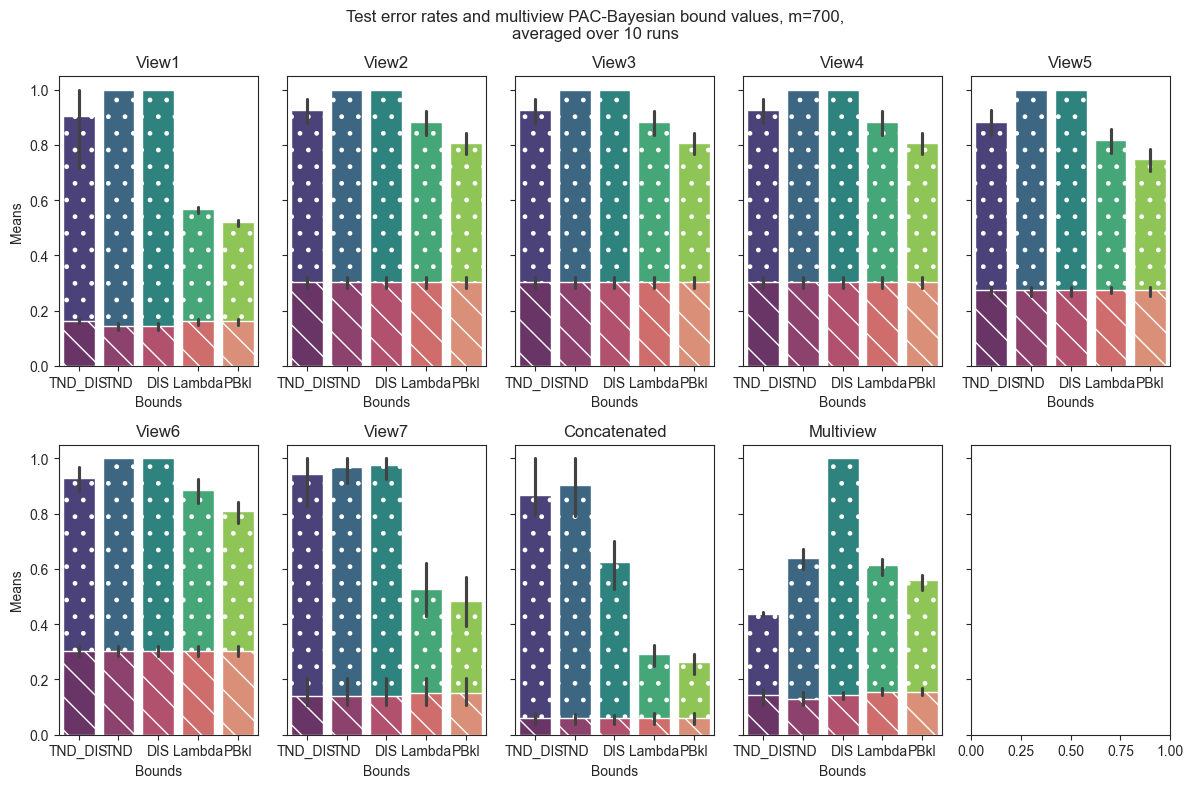

In [11]:
plot_results_grid(df, len(s_labeled["Xs_train"][0]))

In [12]:
def plot_results(experiments, m, runs=RUNS, bounds=bounds):

    sns.set_style(style="ticks")
    bounds_palette = sns.mpl_palette("viridis", n_colors=len(bounds))
    risk_palette = sns.color_palette("flare", n_colors=len(bounds))
    risk_palette.reverse()
    
    ax = sns.barplot(experiments, x='View', hue='Bound_name', y='Bound', width=0.8, hatch='.', palette=bounds_palette)
    ax = sns.barplot(experiments, x='View', hue='Bound_name', y='Risk', width=0.8, hatch='\\', palette=risk_palette)

    plt.title(f'Test error rates and multiview PAC-Bayesian bound values, {m=},\naveraged over {runs} runs')
    plt.xlabel('Views')
    plt.ylabel('Means')
    
    handles, labels = ax.get_legend_handles_labels()
    labels = [labels[i]+" bound" if i < len(labels)/2 else labels[i]+" Gibbs risk" for i in range(len(labels))]

    # Creating a unified legend for both plots
    plt.legend(handles, labels, title="Bounds and risks", loc='upper right', fontsize='medium')
    plt.tight_layout() 
    plt.gcf().set_size_inches(12, 8)
    plt.show()

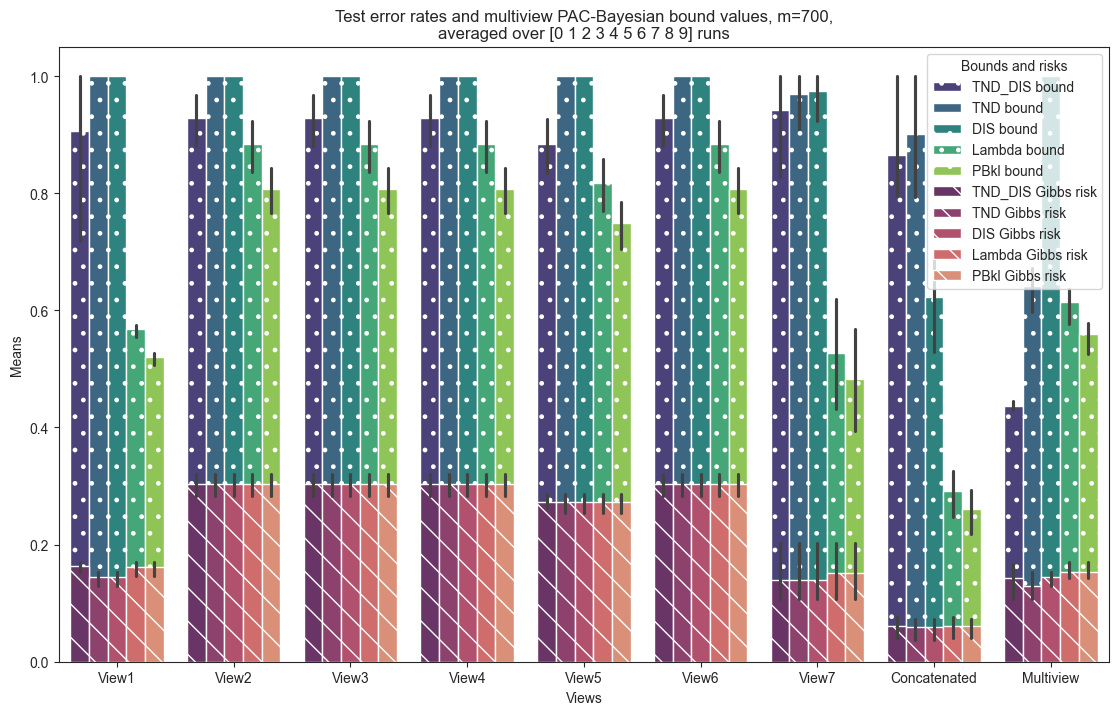

In [13]:
plot_results(df, len(Xs_train[0]))